<h1>Linear Regression between Twitter Sentiment and rates of return<h1>
<blockquote>The purpouse of this experiment is to show that user sentiment manifested on Twitter has indeed an impact on the evolution of stock prices</blockquote> 



<h2>Simple Linear Regression<h2>
<h3>We commence by creating function that will handle the linear regression model called Regression_split, this function randomly splits our data into training and testing sections with a 80/20 ratio and subsequently use the statsmodels library to model the linear regression through the ordinary least squares method, then test it for residual normality, residual heteroskedasticity and residual autocorrelation.  <h3>

In [7]:
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

def Regression_split(x1, y,endog,df,df2):
    X_train, X_test, y_train, y_test = train_test_split(x1,y, test_size=0.2, random_state=42)
    model1 = sm.OLS(y_train[endog], X_train,hasconst=True).fit(cov_type='HAC', cov_kwds={'maxlags':1})
    predictions = model1.predict(X_test)
    print(model1.summary())
    print("Anderson-Darling Test for testing residual normality",sm.stats.diagnostic.normal_ad(model1.resid))
    print("Kolmogorov-Smirnov Test for testing residual normality ",sm.stats.diagnostic.kstest_fit(model1.resid,dist='norm', pvalmethod='approx'))
    print("Breusch-Godfrey Test for residual autocorrelations ",sm.stats.diagnostic.acorr_breusch_godfrey(model1))
    print("Breusch-Pagan Test for residual heteroskedasticity ",sm.stats.diagnostic.het_breuschpagan(model1.resid, X_train, robust=True))
    Date = pd.Series(df2['Date'], name='Date')
    Original = pd.Series(df[endog], name='Original')
    Predictied = pd.Series(predictions, name='Predicted')
    df_fin = y_test.merge(predictions.rename('Predictions'), left_index=True, right_index=True)
    #df_fin = pd.concat([Date, Original, Predictied], axis =1) #facut merge
    #print(df_fin)
    df_fin = df_fin.dropna()
    df_fin.sort_index(inplace=True)
    #print(df_fin)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

#ax.scatter(preddb['Date'],preddb.Error,marker='o', c = 'blue', edgecolors='none', s=30, label='Erorr')
    ax.fill_between(df_fin['Date'],df_fin[endog], df_fin['Predictions'], color ='b', label = 'Prediction Error')    
    ax.scatter(df_fin['Date'], df_fin[endog], alpha=0.8, c='red', edgecolors='none', s=30, label='Historical')
    ax.scatter(df_fin['Date'], df_fin['Predictions'], alpha=0.8, c='green', edgecolors='none', s=30, label='Predicted')

#plt.plot(preddb['Date'],preddb.Error, '-o',zorder=2)
    plt.title('Return prediction')
    plt.legend(loc=3)
    plt.xlabel('Date')
    plt.ylabel('Return %')
    #plt.ylim(-15,17)
    plt.xticks(rotation=45)
    #plt.rcParams["figure.figsize"] = (6,5)
    plt.show()

    '''plt.plot( 'Date', endog, data=df_fin, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'Date', 'Predictions', data=df_fin, marker='', color='red', linewidth=2)
    plt.legend()
    plt.xticks(rotation=45)

  
    plt.show()'''
    Confidence_Interval(df_fin['Predictions'], df_fin[endog],df_fin['Date'])
    #Resid_plot(df_fin, endog)
    accuracy(df_fin, endog)

<h3> We construct the functions needed to perform the linear regressions without spliting the data, this is for the sake of comparison between the models, in order to show how overfitting the data affects our results <h3>
<h3>  The function classic_regression creates the linear model along with various indicators of model fitness and accuracy susch as r squared, pearson's r and adjusted r squared <h3>

In [8]:
from sklearn.linear_model import LinearRegression

def classic_regression(x,y,df,df2, endog):
    model = LinearRegression().fit(x, y)
    yhat = model.predict(x)
    SS_Residual = sum((y-yhat)**2)       
    SS_Total = sum((y-np.mean(y))**2)     
    r_squared = 1 - (float(SS_Residual))/SS_Total
    pearsonr = np.sqrt(r_squared)
    adjusted_r_squared = 1 - (1-r_squared)*(len(y)-1)/(len(y)-x.shape[1]-1)
    print("Correlation coefficient is ", pearsonr)
    print ("R squared is " + str(r_squared),  "Adjusted R squared is "+ str(adjusted_r_squared))
    print('intercept:', model.intercept_)
    print('coefficient:', model.coef_)
    y_pred = model.predict(x)

    Date = pd.Series(df2['Date'])
    Original = pd.Series(df[endog])
    Predictied = pd.Series(y_pred, name='Predicted')
    df_fin = pd.concat([Date, Original, Predictied], axis =1).dropna()
    plt.plot( 'Date', endog, data=df_fin, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'Date', 'Predicted', data=df_fin, marker='', color='red', linewidth=2)
    # show legend
    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Return %')
    # show graph
    plt.show()
    Confidence_Interval(y_pred,df_fin[endog], df_fin['Date'])
    Resid_plot(df_fin, endog)


<h4> get_prediction_interval will calculate the lower and upper bounds of the predicted values using the regression model <h4>
<h4> The function Confidence interval will create a graph comparing the empirical data to the predicted data using the regression model, while also highlighting whether the empirical data has any values that exceed said confidence interval <h4>

In [9]:

def get_prediction_interval(prediction, y_test, test_predictions, pi=.95):
    '''
    get a prediction interval for a linear regression.

    INPUTS:

    - Single prediction,

    - y_test

    - All test set predicitions,

    - Prediction interval threshold (default = .95)

    OUTPUT:

    - Prediction interval for single prediction
    '''

    #get standard deviation of y_test

    sum_errs = np.sum((y_test - test_predictions)**2)

    stdev = np.sqrt(1/(len(y_test)-2)* sum_errs)

    #get interval from standard deviation

    one_minus_pi = 1 - pi

    ppf_lookup = 1 - (one_minus_pi/2)

    z_score = stats.norm.ppf(ppf_lookup)

    interval = z_score * stdev

    #generate prediction interval lower and upper bound

    lower, upper = prediction - interval, prediction + interval

    return lower, prediction, upper
def Confidence_Interval(y_pred,Original,date):

    lower_vet = []

    upper_vet = []

    for i in y_pred:

            lower, predicition, upper = get_prediction_interval(i, Original, y_pred)

            lower_vet.append(lower)

            upper_vet.append(upper)


    plt.fill_between(date,upper_vet, lower_vet, color ='b', label = '95% Confidence Interval')

    plt.plot(date,Original,color='orange', label = 'Historical Values')
    plt.plot(date,y_pred,color='black', label = 'Predicted Values')
    print(y_pred.size)

    plt.xlabel('Date')
    plt.ylabel('Return %')
    plt.title("Predicted Returns")
    plt.legend()
    plt.rcParams["figure.figsize"] = (15,5)
    plt.xticks(rotation=45)
    #plt.ylim(-50,50)
    plt.show()

In [10]:
def accuracy (df, endog):

    MAPE = (df[endog]- df.Predictions)/df[endog]
    MAPE = MAPE.abs()
    print("MAPE value: ", (1/len(MAPE.index) *MAPE.sum()))

    MAE = df[endog]- df.Predictions 
    MAE = MAE.abs()

    print("MAE value: ", (1/len(MAE.index)* MAE.sum()))

    RootMeanSquare=  df.Predictions - df[endog]
    RootMeanSquare = RootMeanSquare**2
    print('RMSE value: ',math.sqrt(RootMeanSquare.mean())) 


<h3> The function Resid_plot will create a graph, showing the position of the model's residuals compared to the predicted values <h3>

In [11]:

def Resid_plot(df_fin, exog):
    Residuals = []
    for index, row in df_fin.iterrows():
        Residuals.append(row['Predicted']-row[exog])
        
    Reziduals = pd.Series(Residuals, name = "Residuals")
    df_fin["Residuals"] = Reziduals
    plt.scatter(df_fin['Predicted'], df_fin['Residuals'], color='r')
    plt.show()

<h3> We will plot the 95% interval of the predicted values compared to the empirical ones in order to check if multiple outliers who couldn't have been predicted exist.<h3>
<h3>Lastly, we chart the residuals compared to the predicted values in order to verifiy if the values are scattered at random or if they are grouped<h3>

<h3>First of all we shall begin our analysis of how Twitter sentiment influences stock returns by using the data colected on NASDAQ sentiment, <br>
Initially we shall use as an exogenous variable the <em>S/P<em> variable, which is short for sentiment/popularity, calculated with the formula </h3> 

$If \sum_{i=1}^n (replies, retweets, likes) \ne 0$ <blockquote> $S/P = S/sum_{i=1}^n (replies, retweets, likes)$</blockquote><br>
$If \sum_{i=1}^n (replies, retweets, likes) = 0$ <blockquote> $S/P = S/1$</blockquote>

<h3> and use it to predict our exogenous variable, <em>return_5</em>, which is the return for a 5 day period. <br>
The variable <em>Const</em> has also been manually added in order to avoid potential runtime errors in the code.<h3>


In [12]:
import warnings
import math
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
path = " Twitter_Sentiment_Analysis/Data/Dataset.xlsx"
df2 = pd.read_excel (path, sheet_name='Nasdaq_R')
endog = 'return_5'
exog = 'S/P'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

<h3> We shall commence by running a split-data regression on the dataset <h3>

                            OLS Regression Results                            
Dep. Variable:               return_5   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1774
Date:                Thu, 29 Jul 2021   Prob (F-statistic):              0.674
Time:                        18:21:19   Log-Likelihood:                -619.60
No. Observations:                 229   AIC:                             1243.
Df Residuals:                     227   BIC:                             1250.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/P            0.0147      0.035      0.421      0.6

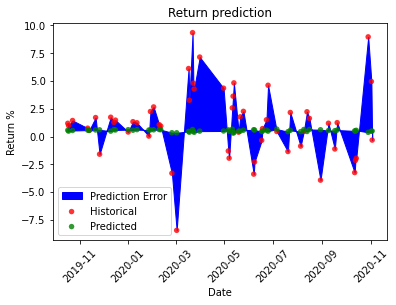

58


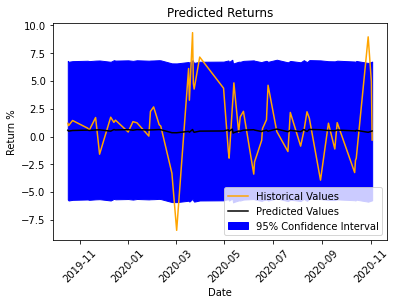

MAPE value:  1.0849134745269648
MAE value:  2.268829637083349
RMSE value:  3.1306015475545843


In [13]:
Regression_split(x1, y,endog,df,df2)

<h3> From the output we can see that this model doesn't fit the data at all. <br>
The R-squared value is 0, thus predicting absolutely nothing about the changes in the dataset. I would be useless to verify the other indicators as it's clear that this model can be discarded.

In [14]:
#classic_regression(x,y,df,df2,endog)

<h3> Even though we used all the available data in training the model, the R-squared value hasn't changed, thus the model remains unusable.

<h3> Next, we shall change the exogenous variable by using the 10 day return variable, <em>return_10</em> <h3>

In [15]:
df2 = pd.read_excel (path, sheet_name='Nasdaq_R')
endog = 'return_10'
exog = 'S/P'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:              return_10   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                  0.006540
Date:                Thu, 29 Jul 2021   Prob (F-statistic):              0.936
Time:                        18:21:19   Log-Likelihood:                -695.27
No. Observations:                 225   AIC:                             1395.
Df Residuals:                     223   BIC:                             1401.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/P            0.0052      0.064      0.081      0.9

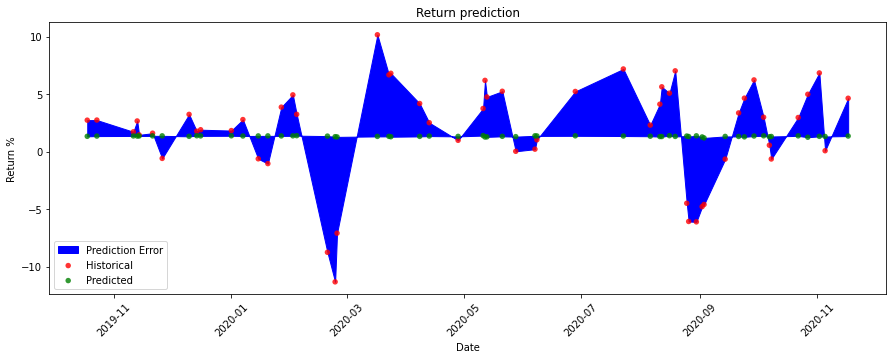

57


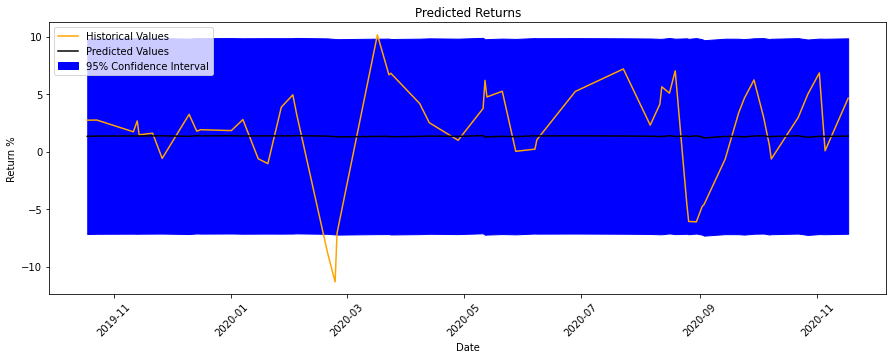

MAPE value:  1.974490326936292
MAE value:  3.2997213532333265
RMSE value:  4.257912238525841


In [16]:
Regression_split(x1, y,endog,df,df2)

<h3> It appears that this model isn't a good fit either, R-squared is also 0

In [17]:
#classic_regression(x,y,df,df2,exog)

<h3> This model seems to follow suit, thus we can conclude that Nasdaq's evolution cannot be modeled through OLS based on its S/P.

After reviewing the results from the models employing the <em>S/P</em> exogenous variable, we shall now use the natural logarhitm of this variable, $S/PLOG = ln(S/P)$. <br>
The first model that will be redone is the one using the <em>return_5</em> vairable as the endogenous one.

In [18]:
df2 = pd.read_excel (path, sheet_name='Nasdaq_R')
endog = 'return_5'
exog = 'S/PLOG'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_5   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.03979
Date:                Thu, 29 Jul 2021   Prob (F-statistic):              0.842
Time:                        18:21:20   Log-Likelihood:                -619.66
No. Observations:                 229   AIC:                             1243.
Df Residuals:                     227   BIC:                             1250.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/PLOG         0.0294      0.147      0.199      0.8

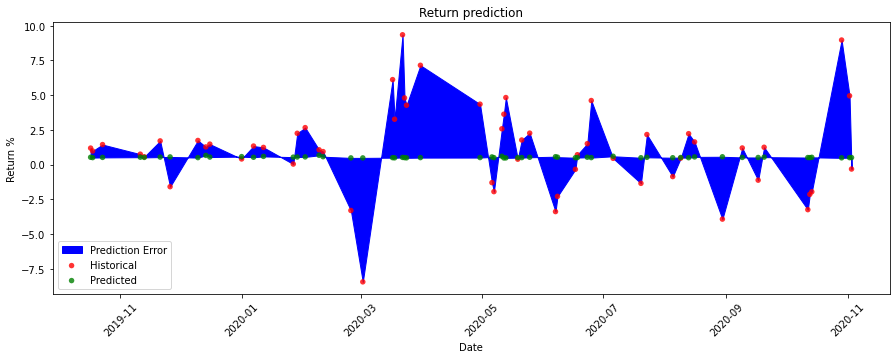

58


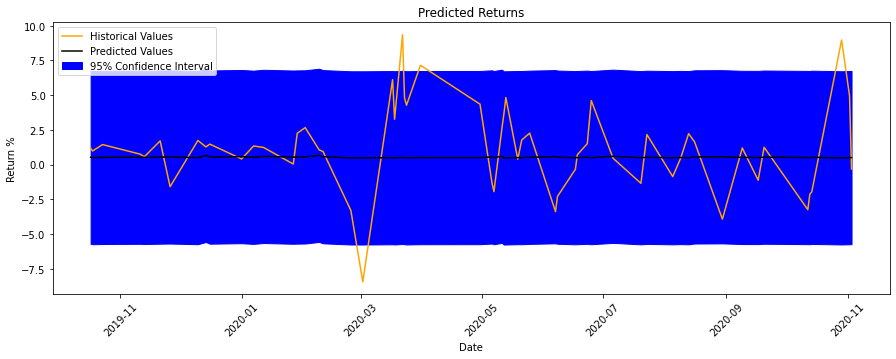

MAPE value:  1.0648359953400655
MAE value:  2.2672873845805377
RMSE value:  3.1279748210318186


In [19]:
Regression_split(x1, y,endog,df,df2)

<h3> It seems that the R-squared value has improved to 0.001, but the Adjusted R-squared value is negative, thus it would be safe to say that this model is also not a good fit.

In [20]:
#classic_regression(x,y,df,df2,endog)

<h3> Using the entire dataset confirms our previous statement that the model isn't a good fit.

Moving on to the 10 day returns.

In [21]:
df2 = pd.read_excel (path, sheet_name='Nasdaq_R')
enog = 'return_10'
exog = 'S/PLOG'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_5   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                   0.03979
Date:                Thu, 29 Jul 2021   Prob (F-statistic):              0.842
Time:                        18:21:21   Log-Likelihood:                -619.66
No. Observations:                 229   AIC:                             1243.
Df Residuals:                     227   BIC:                             1250.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/PLOG         0.0294      0.147      0.199      0.8

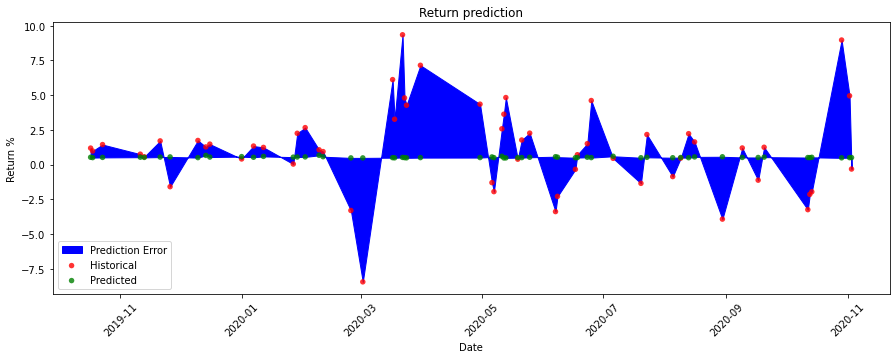

58


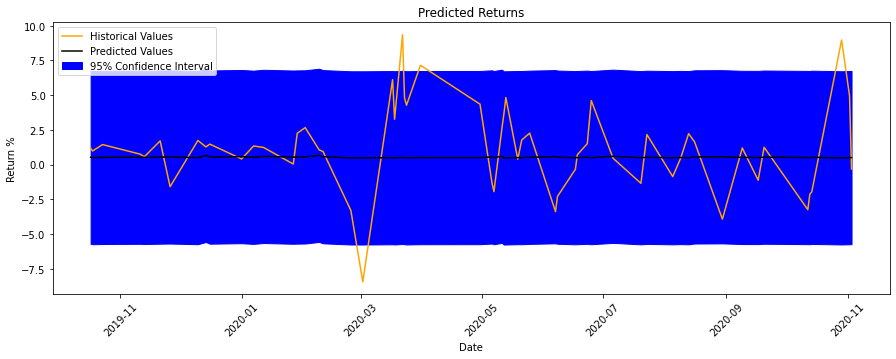

MAPE value:  1.0648359953400655
MAE value:  2.2672873845805377
RMSE value:  3.1279748210318186


In [22]:
Regression_split(x1, y,endog,df,df2)

In [23]:
#classic_regression(x,y,df,df2,endog)

<h3> It appears that even if using <em>S/PLOG</em> as an exogenous variable, the results stay mostly the same, thus indicating that Nasdaq Twitter sentiment has little influence on Nasdaq's evolution and doesn't have predictive properties on its returns.

<h3> Next Nvidia shall be analysed for 3, 5 and 10 day returns using its Twitter sentiment <h3>
First, the non logged exogenous variables will be used

In [25]:
df2 = pd.read_excel (path, sheet_name='NVDA_R')
endog = 'return_4'
exog = 'S/P'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_4   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     20.52
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           1.01e-05
Time:                        18:22:05   Log-Likelihood:                -585.51
No. Observations:                 205   AIC:                             1175.
Df Residuals:                     203   BIC:                             1182.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/P            0.0486      0.011      4.530      0.0

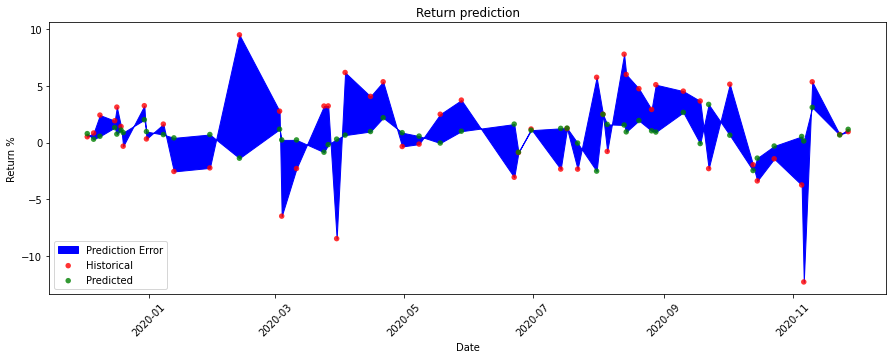

52


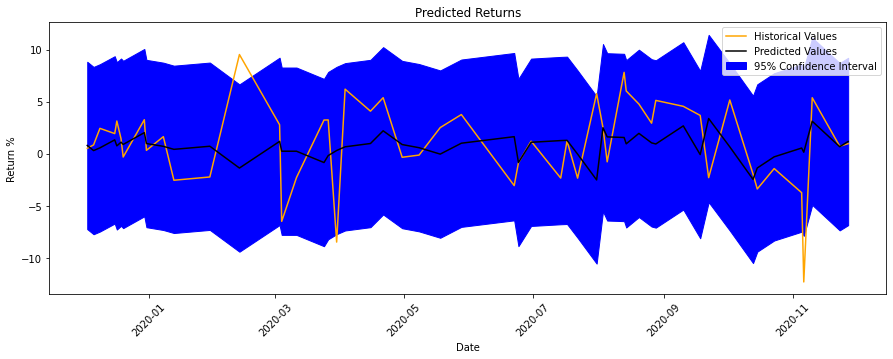

MAPE value:  1.0497009808001267
MAE value:  2.9506300446369726
RMSE value:  4.018651147286295


In [26]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.07, thus accounting for around 7% of the total variation of Nvidia's 4 day stock returns.  <li> A promissing result overall, as the Durbin-Watson statistic shows that the residuals have little to no autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show no autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> The Jarque-Bera, the Omnibus, the Anderson-Darling and the Kolmogorov-Smirnov tests indicate that the residuals do not follow a normal distribution, but it was to be expected as stock return's rarely follow it. This has the side-effect of making the predictions using this model more innacurate. </li> <li> Lastly the Q-Q plot shows that the model's residuals don't conform to a normal distribution



In [27]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

In [28]:
endog = 'return_5'
exog = 'S/P'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_5   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     15.63
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           0.000106
Time:                        18:22:05   Log-Likelihood:                -660.49
No. Observations:                 204   AIC:                             1325.
Df Residuals:                     202   BIC:                             1332.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/P            0.0623      0.016      3.954      0.0

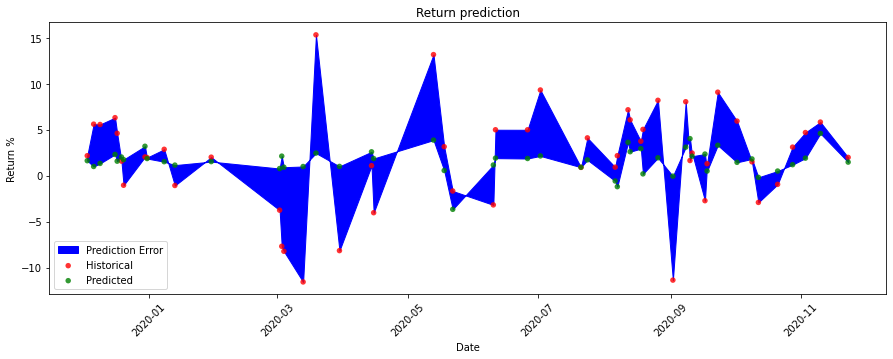

51


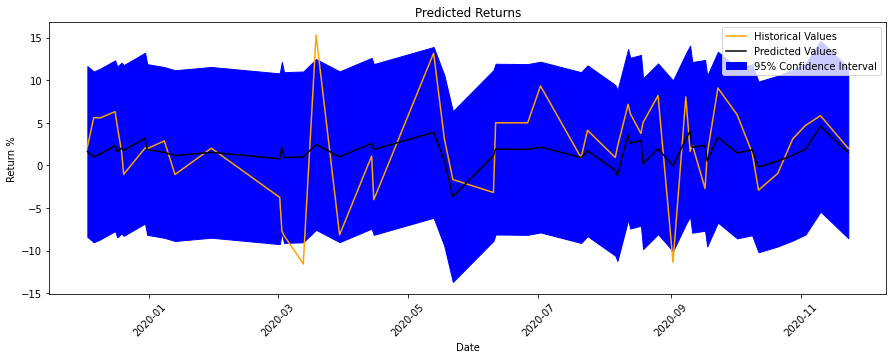

MAPE value:  0.8486652210375328
MAE value:  3.813078919078853
RMSE value:  5.014726336329607


In [29]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.055, thus accounting for around 6% of the total variation of Nvidia's 5 day stock returns.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little to no autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show no autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> The Jarque-Bera, the Omnibus, the Anderson-Darling and the Kolmogorov-Smirnov tests indicate that the residuals do not follow a normal distribution, but it was to be expected as stock return's rarely follow it. This has the side-effect of making the predictions using this model more innacurate. </li> 

In [30]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

In [31]:
endog = 'return_10'
exog = 'S/P'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:              return_10   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     11.35
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           0.000908
Time:                        18:22:06   Log-Likelihood:                -696.03
No. Observations:                 200   AIC:                             1396.
Df Residuals:                     198   BIC:                             1403.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/P            0.0647      0.019      3.369      0.0

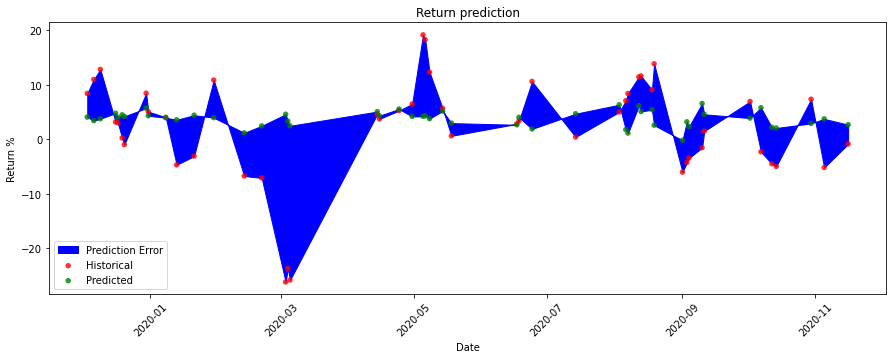

50


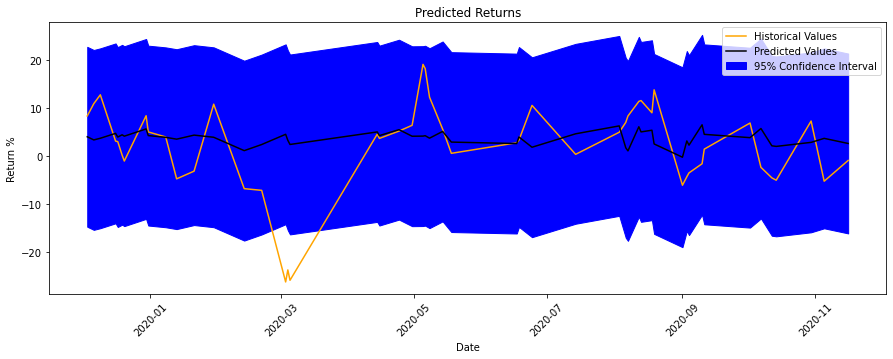

MAPE value:  1.6544979850478294
MAE value:  6.656871375352493
RMSE value:  9.359828814930047


In [32]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.035, thus accounting for around 4% of the total variation of Nvidia's 10 day stock returns.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little postivie autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show no autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> The Jarque-Bera, the Omnibus, the Anderson-Darling and the Kolmogorov-Smirnov tests indicate that the residuals do not follow a normal distribution, but it was to be expected as stock return's rarely follow it. This has the side-effect of making the predictions using this model more innacurate. </li> 

In [33]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

<h3> Now using the logged exogenous variables <h3>

In [35]:
endog = 'return_4'
exog = 'S/PLOG'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_4   R-squared:                       0.134
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     34.88
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           1.46e-08
Time:                        18:22:16   Log-Likelihood:                -578.59
No. Observations:                 205   AIC:                             1161.
Df Residuals:                     203   BIC:                             1168.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/PLOG         0.6111      0.103      5.906      0.0

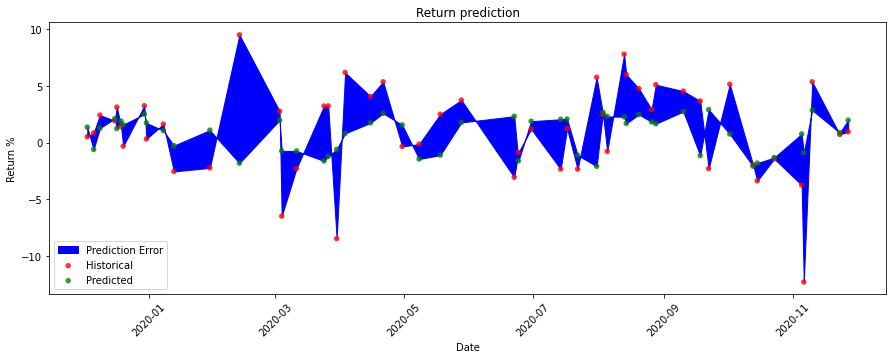

52


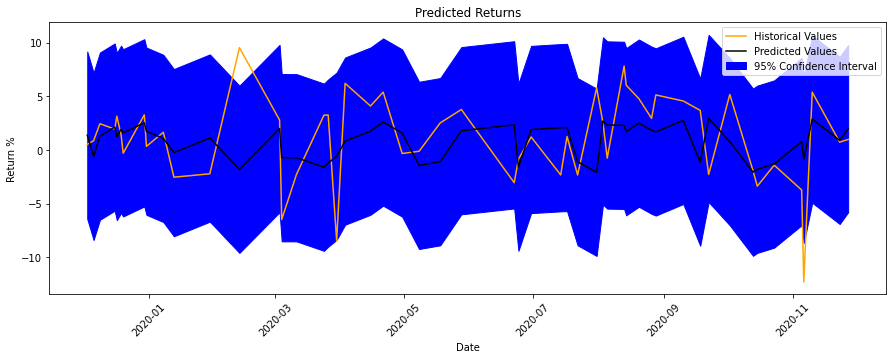

MAPE value:  1.3248350165978287
MAE value:  2.905028862055073
RMSE value:  3.89874453929933


In [36]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.13, thus accounting for around 13% of the total variation of Nvidia's 4 day stock returns, a clear improvement over the nonloged variable.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little to no autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show no autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> The Jarque-Bera, the Omnibus, the Anderson-Darling and the Kolmogorov-Smirnov tests indicate that the residuals do not follow a normal distribution, but it was to be expected as stock return's rarely follow it. This has the side-effect of making the predictions using this model more innacurate. </li> <li> 

In [37]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

In [38]:
endog = 'return_5'
exog = 'S/PLOG'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_5   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     30.96
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           8.28e-08
Time:                        18:22:16   Log-Likelihood:                -655.02
No. Observations:                 204   AIC:                             1314.
Df Residuals:                     202   BIC:                             1321.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/PLOG         0.7893      0.142      5.565      0.0

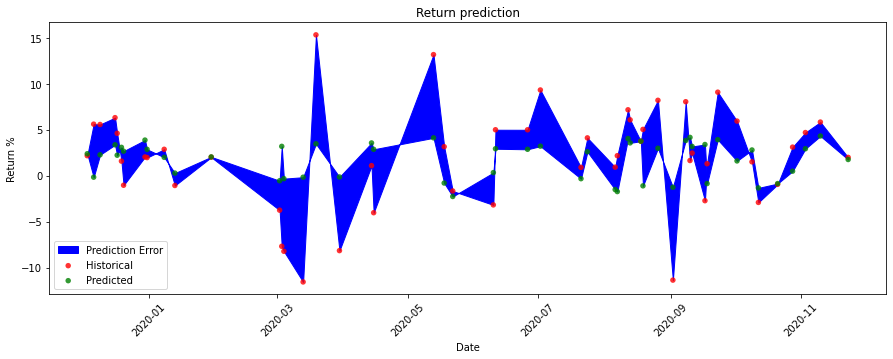

51


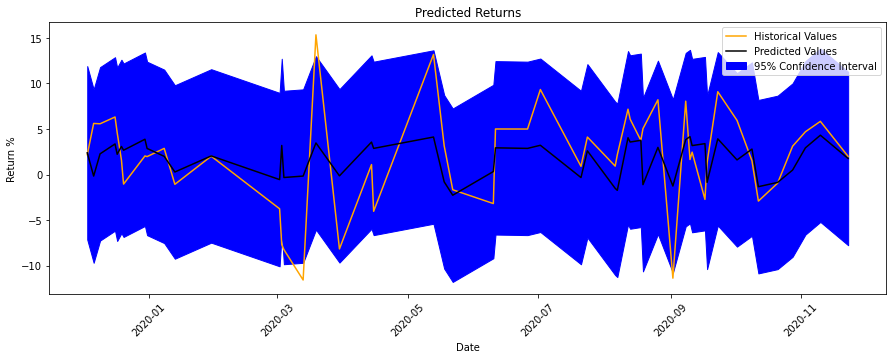

MAPE value:  0.8900401006027547
MAE value:  3.6372615752194957
RMSE value:  4.760180999185697


In [39]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.104, thus accounting for around 10% of the total variation of Nvidia's 5 day stock returns, a clear improvement over the nonloged variable.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little to no autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show no autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> The Jarque-Bera, the Omnibus, the Anderson-Darling and the Kolmogorov-Smirnov tests indicate that the residuals do not follow a normal distribution, but it was to be expected as stock return's rarely follow it. This has the side-effect of making the predictions using this model more innacurate. </li> <li> Lastly the Q-Q plot shows that the model's residuals don't conform to a normal distribution

In [40]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

In [41]:
endog = 'return_10'
exog = 'S/PLOG'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:              return_10   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     19.95
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           1.34e-05
Time:                        18:22:17   Log-Likelihood:                -692.53
No. Observations:                 200   AIC:                             1389.
Df Residuals:                     198   BIC:                             1396.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/PLOG         0.8357      0.187      4.466      0.0

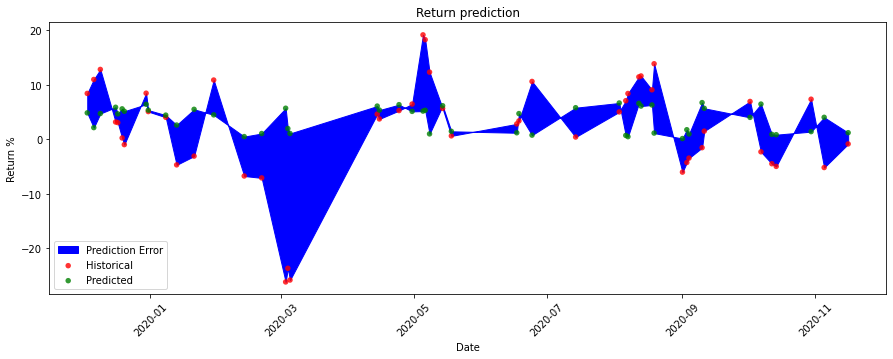

50


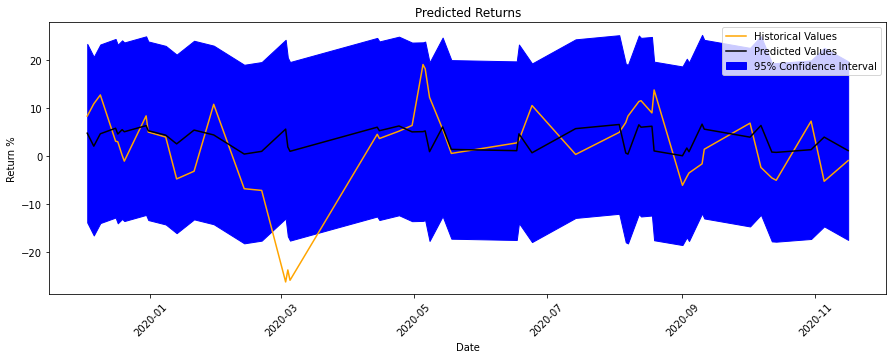

MAPE value:  1.7657897951978654
MAE value:  6.700645126743315
RMSE value:  9.299878087095768


In [42]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.068, thus accounting for around 7% of the total variation of Nvidia's 10 day stock returns, a clear improvement over the nonloged variable.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little to no autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show no autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> The Jarque-Bera, the Omnibus, the Anderson-Darling and the Kolmogorov-Smirnov tests indicate that the residuals do not follow a normal distribution, but it was to be expected as stock return's rarely follow it. This has the side-effect of making the predictions using this model more innacurate. </li> <li> Lastly the Q-Q plot shows that the model's residuals don't conform to a normal distribution

In [43]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

<h3> Thus, after analysing the impact of Twitter sentiment on Nvidia's stock returns we can say that they do indeed have a clear effect on them, but the OLS model's predictive ability suffers from the abnormality of the residual distribution

<h3> Moving on to AMD with the exogenous variable unlogged <h3>

In [44]:
df2 = pd.read_excel (path, sheet_name='AMD_R')
endog = 'return_4'
exog = 'S/P'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_3   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     11.38
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           0.000900
Time:                        18:22:17   Log-Likelihood:                -570.07
No. Observations:                 190   AIC:                             1144.
Df Residuals:                     188   BIC:                             1151.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/P            0.0254      0.008      3.374      0.0

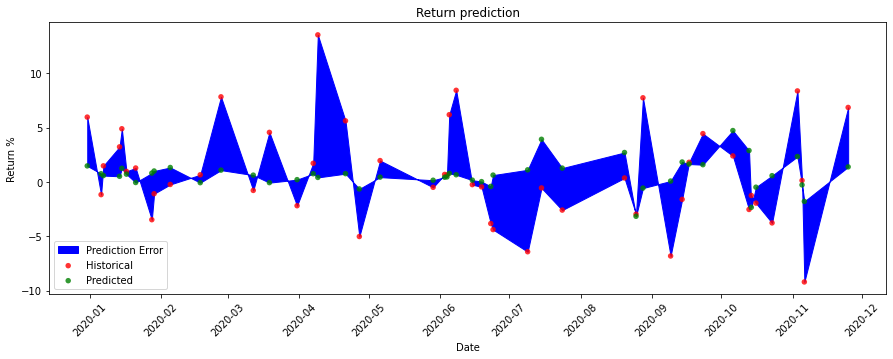

48


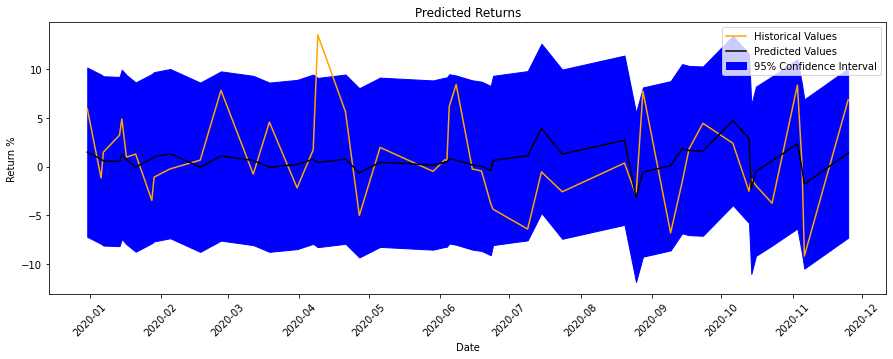

MAPE value:  1.4167121210774671
MAE value:  3.3648578767077293
RMSE value:  4.341105589373714


In [45]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.04, thus accounting for around 4% of the total variation of AMD's 4 day stock returns.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little negative autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show significant autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> The Anderson-Darling and the Kolmogorov-Smirnov tests indicate that the residuals follow a normal distribution. This has the side-effect of making the predictions using this model more accurate. </li> 

In [46]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

In [47]:
endog = 'return_5'
exog = 'S/P'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_5   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     14.38
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           0.000202
Time:                        18:22:18   Log-Likelihood:                -626.36
No. Observations:                 188   AIC:                             1257.
Df Residuals:                     186   BIC:                             1263.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/P            0.0403      0.011      3.791      0.0

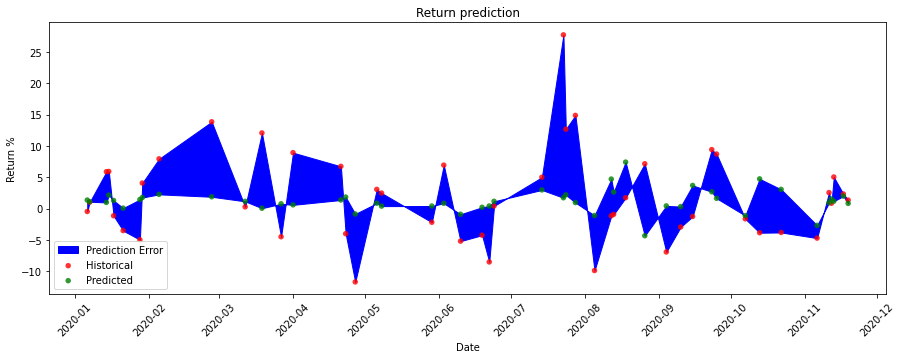

48


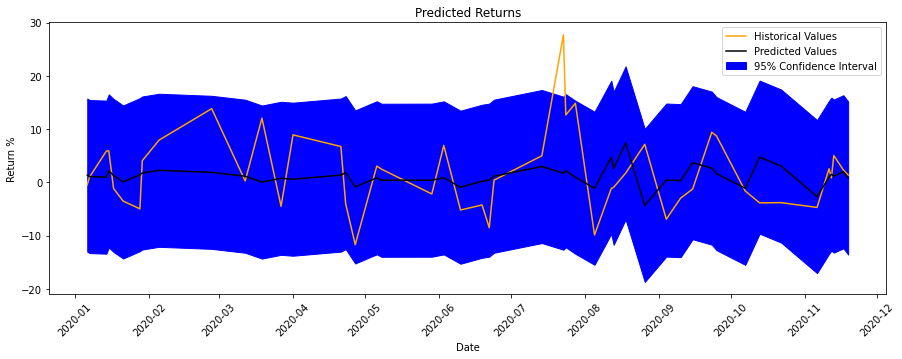

MAPE value:  1.3108231984057968
MAE value:  5.52406145242808
RMSE value:  7.184464714060284


In [48]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.057, thus accounting for around 6% of the total variation of AMD's 5 day stock returns.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little negative autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show significant autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> The Kolmogorov-Smirnov test indicates that the residuals follow a normal distribution. This has the side-effect of making the predictions using this model more accurate. </li> 

In [49]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

In [50]:
endog = 'return_10'
exog = 'S/P'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:              return_10   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     30.54
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           1.12e-07
Time:                        18:22:19   Log-Likelihood:                -683.90
No. Observations:                 184   AIC:                             1372.
Df Residuals:                     182   BIC:                             1378.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/P            0.0758      0.014      5.526      0.0

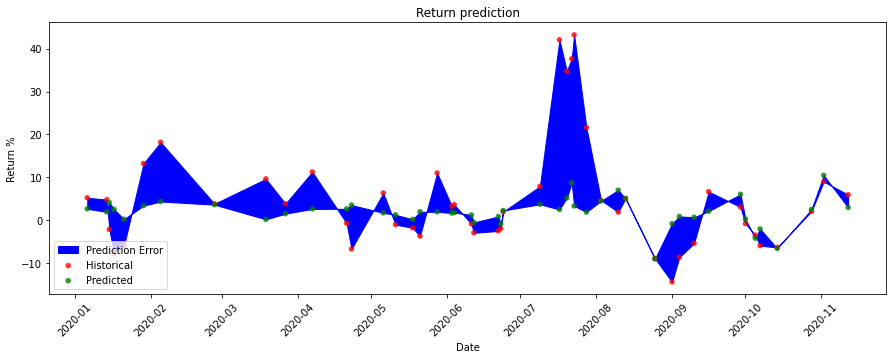

47


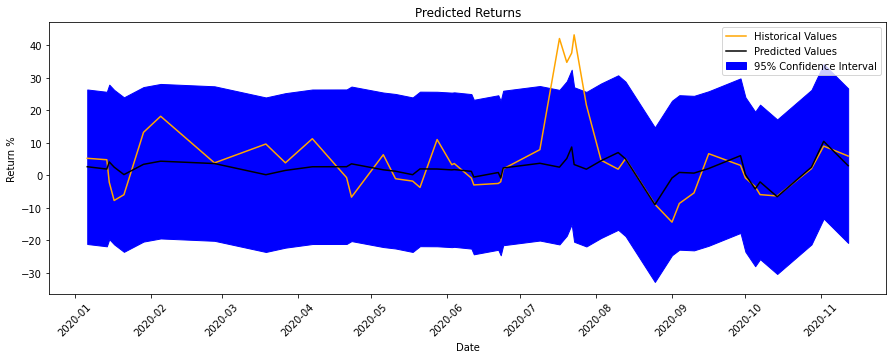

MAPE value:  0.9626094687772114
MAE value:  7.173993783093647
RMSE value:  11.8592196744386


In [51]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.095, thus accounting for around 10% of the total variation of AMD's 10 day stock returns.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little negative autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show significant autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> The Anderson-Darling test indicates that the residuals follow a normal distribution. This has the side-effect of making the predictions using this model more accurate. </li> 

In [52]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

<h3> Now for the logged exogenous variable <h3>

In [53]:
endog = 'return_4'
exog = 'S/PLOG'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_3   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     8.987
Date:                Thu, 29 Jul 2021   Prob (F-statistic):            0.00309
Time:                        18:22:19   Log-Likelihood:                -569.90
No. Observations:                 190   AIC:                             1144.
Df Residuals:                     188   BIC:                             1150.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/PLOG         0.3694      0.123      2.998      0.0

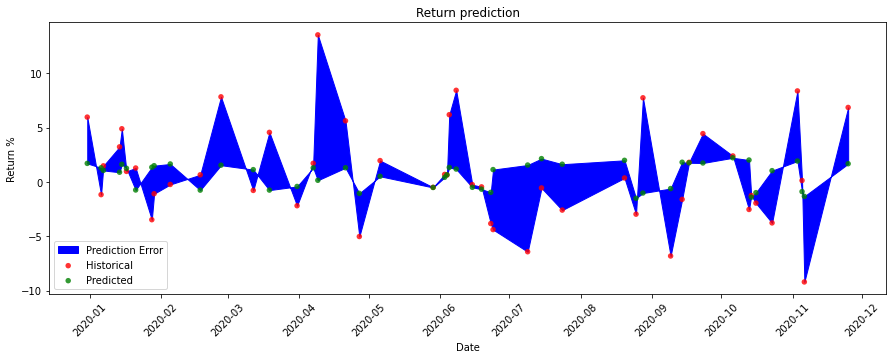

48


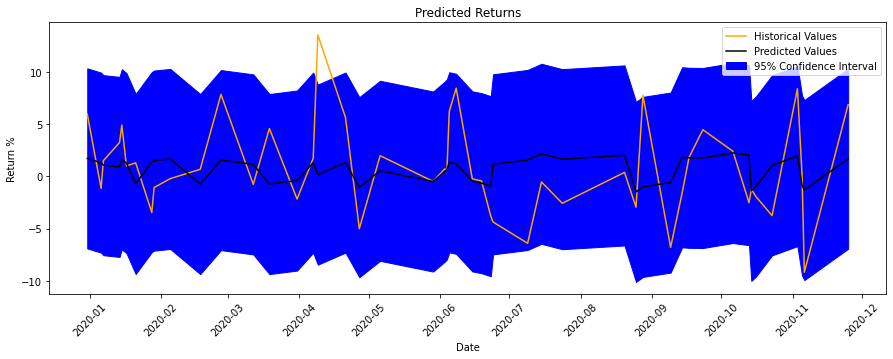

MAPE value:  1.3739675210656233
MAE value:  3.2517619225119163
RMSE value:  4.30359954780949


In [54]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.041, thus accounting for around 4% of the total variation of AMD's 4 day stock returns, not much of a difference.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little negative autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show significant autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> The Anderson-Darling and Kolmogorov-Smirnov tests indicate that the residuals follow a normal distribution. This has the side-effect of making the predictions using this model more accurate compared to the nonlogged model. </li> 

In [55]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

In [56]:
endog = 'return_5'
exog = 'S/PLOG'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_5   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     15.68
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           0.000107
Time:                        18:22:20   Log-Likelihood:                -625.09
No. Observations:                 188   AIC:                             1254.
Df Residuals:                     186   BIC:                             1261.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/PLOG         0.6493      0.164      3.959      0.0

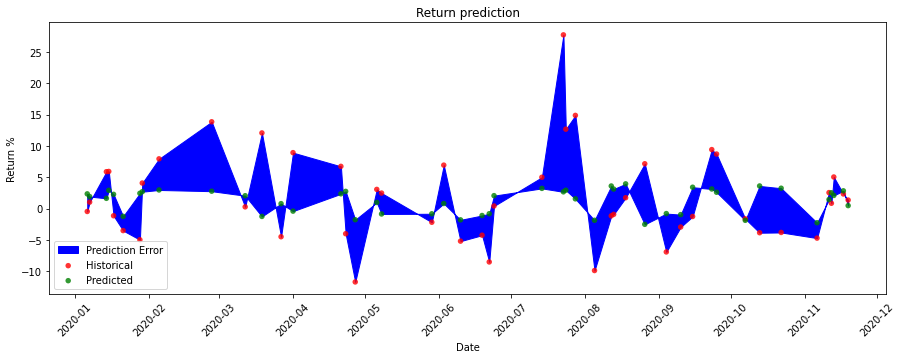

48


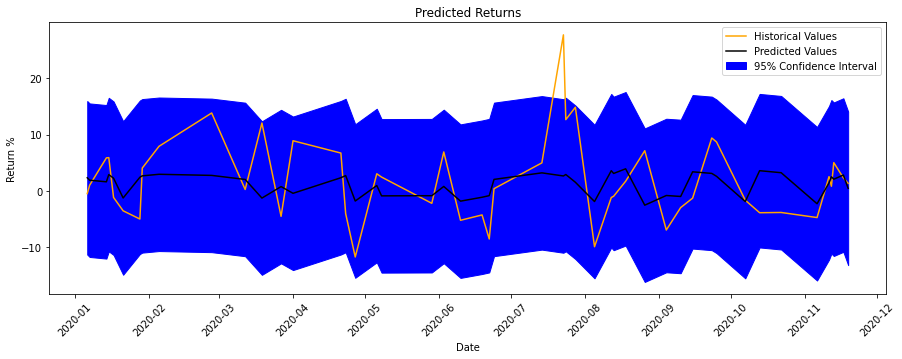

MAPE value:  1.408738196141309
MAE value:  5.190631999217399
RMSE value:  6.80742327827741


In [57]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.069, thus accounting for around 7% of the total variation of AMD's 5 day stock returns, a small improvement over the nonloged variable.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little negative autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show significant autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> The Kolmogorov-Smirnov test indicates that the residuals follow a normal distribution. This has the side-effect of making the predictions using this model more accurate compared to the nonlogged model. </li> 

In [58]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

In [59]:
endog = 'return_10'
exog = 'S/PLOG'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:              return_10   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     34.09
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           2.38e-08
Time:                        18:22:20   Log-Likelihood:                -681.31
No. Observations:                 184   AIC:                             1367.
Df Residuals:                     182   BIC:                             1373.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/PLOG         1.2569      0.215      5.838      0.0

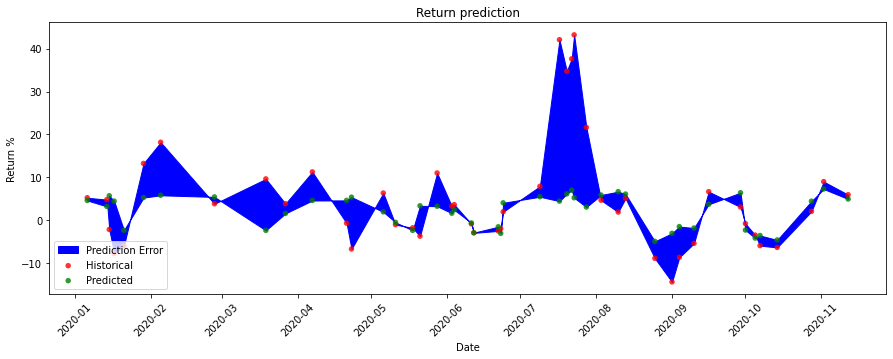

47


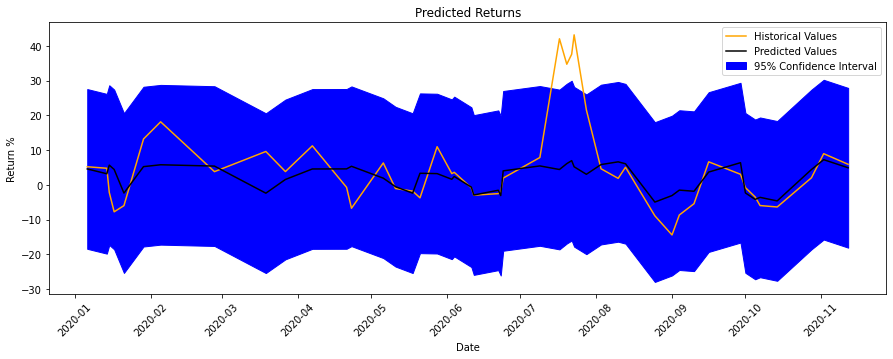

MAPE value:  0.9239658343849154
MAE value:  6.8115993546195615
RMSE value:  11.475868214346386


In [60]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.12, thus accounting for around 12% of the total variation of AMD's 10 day stock returns, a significant improvement over the nonloged variable.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little negative autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show significant autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> All the tests show that the residuals do not follow a normal distribution. This has the side-effect of making the predictions using this model less accurate compared to the nonlogged model. </li> 

In [61]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

<h3> Thus, after analysing the impact of Twitter sentiment on AMD's stock returns we can say that they do indeed have a clear effect on them, the normal distribution of the residuals manages to confer a predictive capability to the OLS model, thus entertaining the notion that a sentiment-based OLS model could be used in stock market forecasting.

<h3> And finally we shall analyse Tesla, starting with the non-logged exogenous variable<h3>

In [62]:
df2 = pd.read_excel (path, sheet_name='TSLA_R')
endog = 'return_4'
exog = 'S/P'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_3   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     20.97
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           8.08e-06
Time:                        18:22:21   Log-Likelihood:                -715.07
No. Observations:                 208   AIC:                             1434.
Df Residuals:                     206   BIC:                             1441.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/P            0.0045      0.001      4.579      0.0

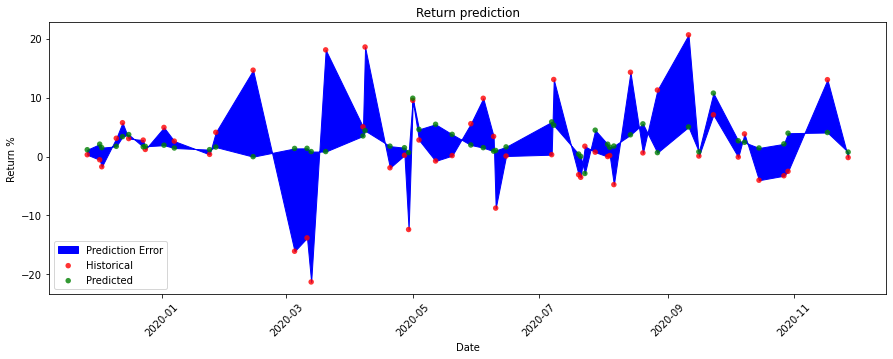

53


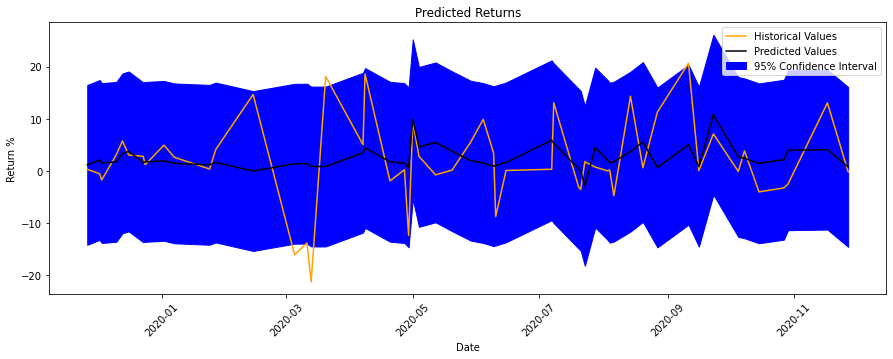

MAPE value:  32.791209267206355
MAE value:  5.571439420639292
RMSE value:  7.674873489122662


In [63]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.088, thus accounting for around 9% of the total variation of Tesla's 4 day stock returns.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little positive autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show significant autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> All the tests show that the residuals do not follow a normal distribution which will hinder the accuracy of the model. </li> 

In [64]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

In [65]:
endog = 'return_5'
exog = 'S/P'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_5   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     29.60
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           1.51e-07
Time:                        18:22:21   Log-Likelihood:                -805.73
No. Observations:                 207   AIC:                             1615.
Df Residuals:                     205   BIC:                             1622.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/P            0.0075      0.001      5.440      0.0

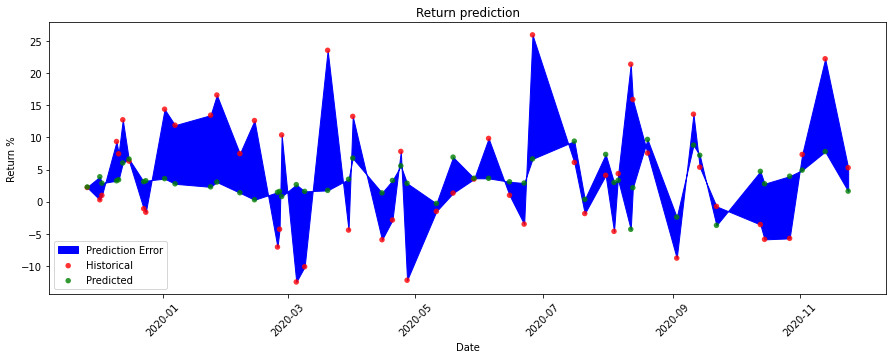

52


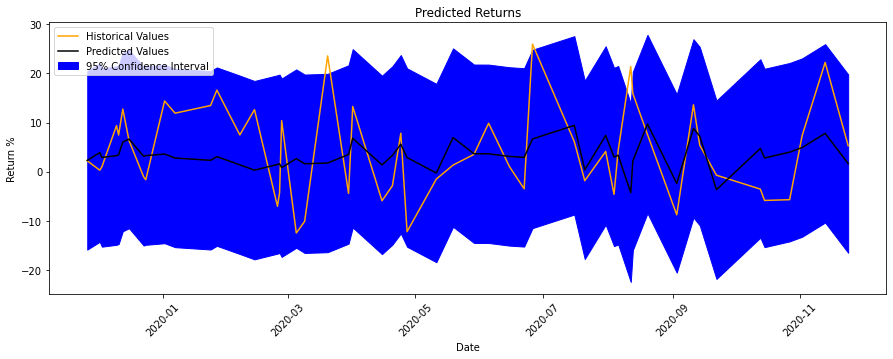

MAPE value:  1.3682861370709012
MAE value:  7.218215765966906
RMSE value:  9.073518486308682


In [66]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.111, thus accounting for around 11% of the total variation of Tesla's 5 day stock returns.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little to no autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show significant autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> All the tests show that the residuals do not follow a normal distribution which will hinder the accuracy of the model. </li> 

In [67]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

In [68]:
endog = 'return_10'
exog = 'S/P'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:              return_10   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     10.90
Date:                Thu, 29 Jul 2021   Prob (F-statistic):            0.00114
Time:                        18:22:22   Log-Likelihood:                -873.51
No. Observations:                 203   AIC:                             1751.
Df Residuals:                     201   BIC:                             1758.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/P            0.0061      0.002      3.302      0.0

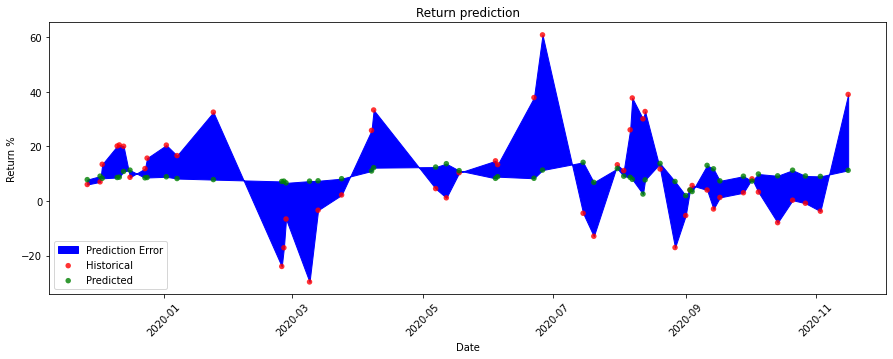

51


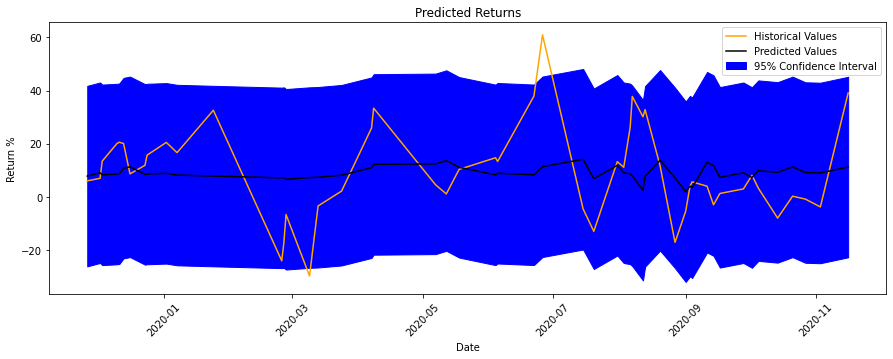

MAPE value:  2.304201957714582
MAE value:  13.121833515258471
RMSE value:  16.965669202604467


In [69]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.03, thus accounting for around 3% of the total variation of Tesla's 10 day stock returns.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little to no autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show significant autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> All the tests show that the residuals do not follow a normal distribution which will hinder the accuracy of the model. </li> 

In [70]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

<h3> And now for the logged exogenous variable <h3>

In [71]:
endog = 'return_4'
exog = 'S/PLOG'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_3   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     24.43
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           1.60e-06
Time:                        18:22:22   Log-Likelihood:                -715.69
No. Observations:                 208   AIC:                             1435.
Df Residuals:                     206   BIC:                             1442.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/PLOG         0.4234      0.086      4.942      0.0

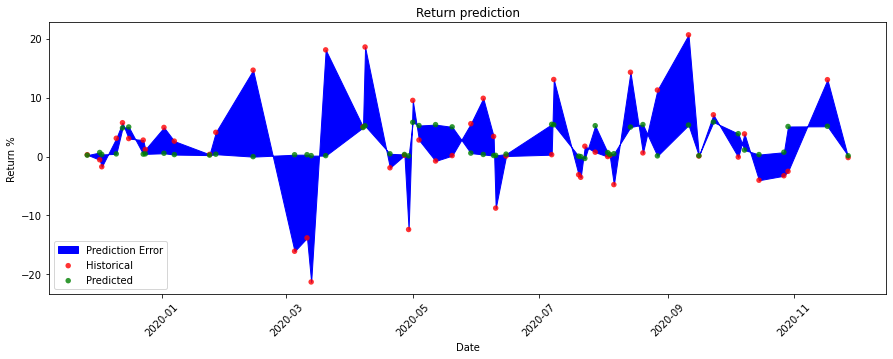

53


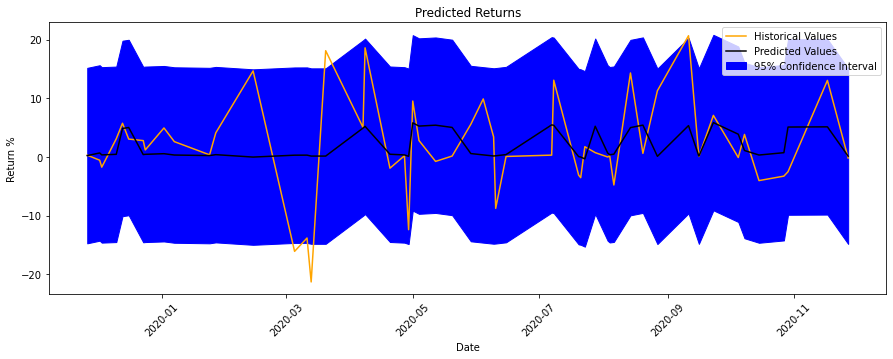

MAPE value:  12.511576277004961
MAE value:  5.378214457223832
RMSE value:  7.485616117362268


In [72]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.083, thus accounting for around 8% of the total variation of Tesla's 4 day stock returns, a slight deterioration of the model's fitness compared to the nonloged variable.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have a slight positive autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show significant autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> All the tests show that the residuals do not follow a normal distribution which will hinder the accuracy of the model. </li> 

In [73]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

In [74]:
endog = 'return_5'
exog = 'S/PLOG'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:               return_5   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     53.33
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           6.12e-12
Time:                        18:22:23   Log-Likelihood:                -798.91
No. Observations:                 207   AIC:                             1602.
Df Residuals:                     205   BIC:                             1608.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/PLOG         0.9289      0.127      7.303      0.0

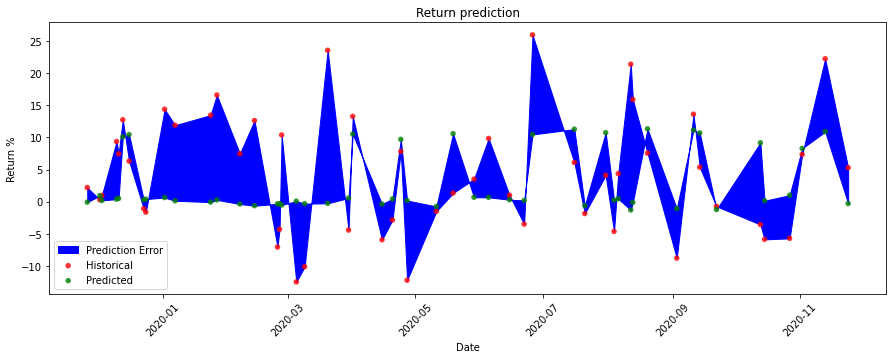

52


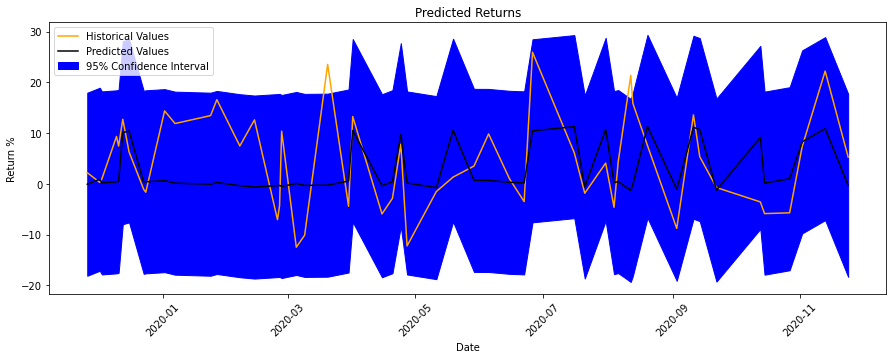

MAPE value:  1.0604120588098067
MAE value:  7.115193129086511
RMSE value:  9.016929503639542


In [75]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.167, thus accounting for around 17% of the total variation of Tesla's 5 day stock returns, a significant of the model's fitness compared to the nonloged variable.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have little to no autocorelation at the first lag, but the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show significant autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the null hypothesis that our data's error variances are all equal</li>  <li> All the tests show that the residuals do not follow a normal distribution which will hinder the accuracy of the model. </li> 

In [76]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

In [77]:
endog = 'return_10'
exog = 'S/PLOG'
df = df2[[endog,'Const',exog]].dropna()
x1 = df[[exog,'Const']]
y = df2[[endog,'Date']].dropna()

x = np.array(df[exog]).reshape(-1,1)

                            OLS Regression Results                            
Dep. Variable:              return_10   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     17.08
Date:                Thu, 29 Jul 2021   Prob (F-statistic):           5.25e-05
Time:                        18:22:23   Log-Likelihood:                -870.32
No. Observations:                 203   AIC:                             1745.
Df Residuals:                     201   BIC:                             1751.
Df Model:                           1                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
S/PLOG         0.8337      0.202      4.133      0.0

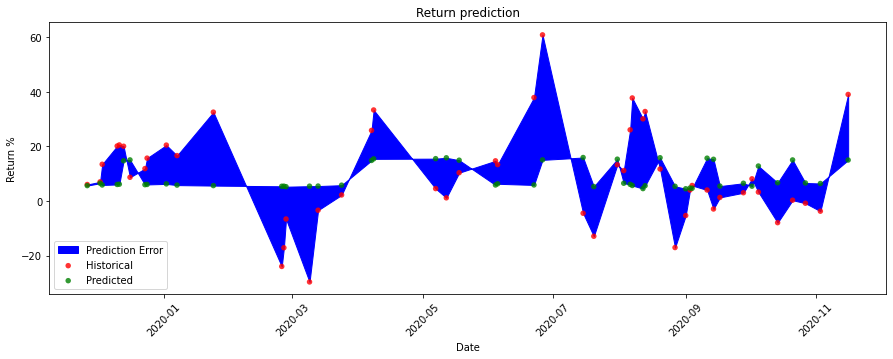

51


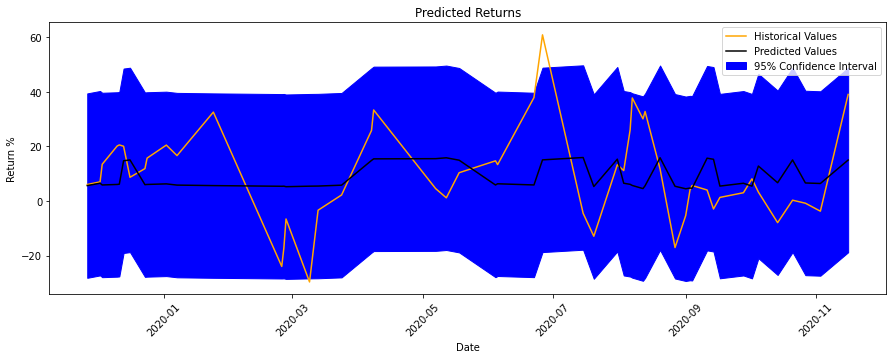

MAPE value:  2.5395882874384306
MAE value:  13.526635869263105
RMSE value:  16.914491388464995


In [78]:
Regression_split(x1, y,endog,df,df2)

<ul> It appears that the Adjusted R-squared value is 0.06, thus accounting for around 6% of the total variation of Tesla's 10 day stock returns, a significant of the model's fitness compared to the nonloged variable.  <li> A good result overall, as the Durbin-Watson statistic shows that the residuals have a clear autocorelation at the first lag, this is supported by the Breuch-Godfrey test that shows a p-value higher than 0.05 thus confirming that the residuals do indeed show significant autocorelation.</li>  <li>The Breuch-Pagan test for Heteroskedasticity shows a p-value greater than 0.05, thus leading to the acceptance of the alternate hypothesis that our data's error variances are different from eachother</li>  <li> All the tests show that the residuals do not follow a normal distribution which will hinder the accuracy of the model. </li>

In [79]:
#classic_regression(x,y,df,df2,endog)

By running a regression model on the entirety of the dataset, we are able to plot the difference between the predicted values and the real values. The results show that while the model manages to predict whether the stock returns will rise or fall, it doesn't predict the sudden spikes. Nonetheless, most empirical values fall between the bounds of the model's confidence interval.

<h3> Thus, after analysing the impact of Twitter sentiment on Tesla's stock returns we can say that they do indeed have a clear effect on them, but the OLS model isn't the best fit for this phenomenon as several models have shown signs of residual heteroskedasticity, abnormality and autocorellation, further more, these analyses show that other statistical models must be studied for a sentiment-based prediction for Tesla's stock returns.